In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

df = pd.read_csv('./dataset/preprocessed.csv')

X, y = df.iloc[:, :-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12599, 59) (12599,)


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10079, 59) (10079,)
Test set:  (2520, 59) (2520,)


In [3]:
# Fill missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [4]:
def cross_validation_score(estimator):
    scores = cross_val_score(
        estimator, X_test, y_test, cv=10, n_jobs=-1,
        scoring='roc_auc'
    )
    
    return scores.mean(), scores.std()


def plot_cross_validation(title, X, Y, error, xlabel, ylabel='ROC AUC'):
    plt.title(title)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


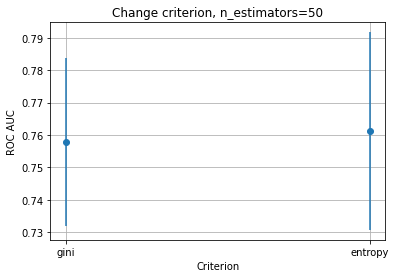

In [5]:
from sklearn.ensemble import RandomForestClassifier

title = 'Change criterion, n_estimators=50'
xlabel = 'Criterion'
criterions = ['gini', 'entropy']
means = []
stddevs = []

for criterion in tqdm(criterions):
    clf = RandomForestClassifier(criterion=criterion, n_estimators=50, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)
    
plot_cross_validation(title, criterions, means, stddevs, xlabel)
plt.savefig('./figure/RF_change_criterion.png')
plt.show()

100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


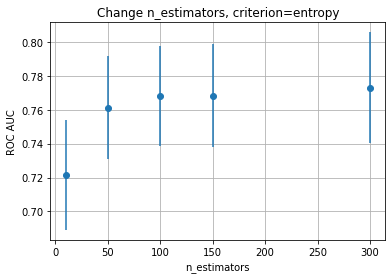

In [6]:
title = 'Change n_estimators, criterion=entropy'
xlabel = 'n_estimators'
N = [10, 50, 100, 150, 300]
means = []
stddevs = []

for n in tqdm(N):
    clf = RandomForestClassifier(criterion='entropy', n_estimators=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, N, means, stddevs, xlabel)
plt.savefig('./figure/RF_change_n_estimators.png')
plt.show()

In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score

rf = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                            random_state=rng)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('ROC AUC on test set: ', roc_auc_score(y_test, y_pred))

Accuracy on test set:  0.751984126984127
ROC AUC on test set:  0.7428147054080413


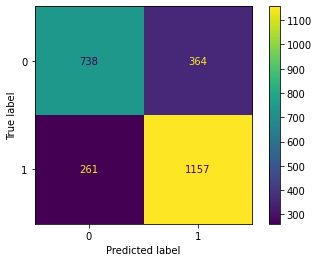

In [8]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_test, y_test)
plt.savefig('./figure/RF_confmat.png')

In [9]:
# Visualize the impurity-based importance

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], 
             axis=0)

# Only inspect top-k most important features
k = 10
topk = importances.argsort()[-k:][::-1]

feature_names = np.array(X.columns)[topk]
importances = importances[topk]
std = std[topk]

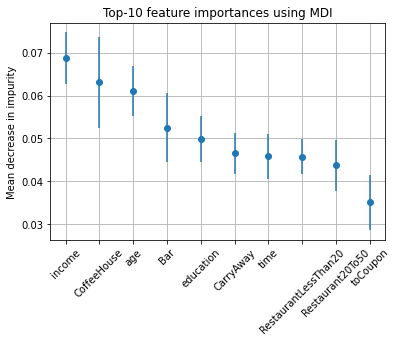

In [10]:
title = 'Top-%d feature importances using MDI' % (k)
ylabel = 'Mean decrease in impurity'

plt.title(title)
plt.ylabel(ylabel)
plt.xticks(rotation=45)
plt.grid()

plt.errorbar(feature_names, importances, std, linestyle='None', marker='o')
plt.savefig('./figure/RF_top%d_MDI_importances.png' % (k))
plt.show()

In [11]:
# Visualize feature importance based on feature permutation 
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, scoring='roc_auc',
                                n_repeats=10, random_state=seed, 
                                n_jobs=-1)
importances = result.importances_mean
std = result.importances_std 

# Only inspect top-k
topk = importances.argsort()[-k:][::-1]
feature_names = np.array(X.columns)[topk]
importances = importances[topk]
std = std[topk]

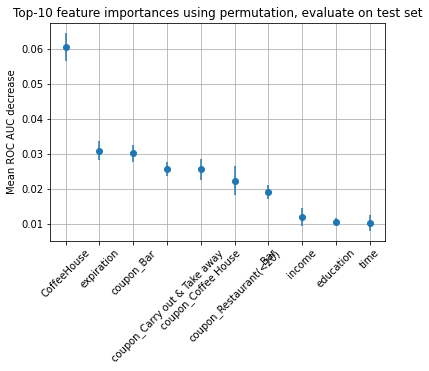

In [12]:
title = 'Top-%d feature importances using permutation, evaluate on test set' % (k)
ylabel = 'Mean ROC AUC decrease'

plt.title(title)
plt.ylabel(ylabel)
plt.xticks(rotation=45)
plt.grid()

plt.errorbar(feature_names, importances, std, linestyle='None', marker='o')
plt.savefig('./figure/RF_top%d_feature_importances_permutation.png' % (k))
plt.show()